<a href="https://colab.research.google.com/github/cchummer/sec-api/blob/main/s1_topic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Analysis

LDA is a 'bag-of-words' style model, which essentially treats a corpus and tokens as a big 2D matrix (rows = documents, columns = tokens), from which is calculated a topic-feature matrix and a document-topic matrix. Tokens (words, key parts of words, etc) are simply counted and grouped by their appearences together. Order is not considered or analyzed.



#### Vectorization + Tokenization
There are a couple of options of how exactly to turn a list of documents into an optimal matrix for analysis. Scikit-learn has a nice overview [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

For LDA, only raw term counts matter, so vectorization options are limited. Choices exist in how exactly to tokenize the data (n-grams and other preprocessecing configurables). We will start off with as little optimization as needed and move forward.

I have uploaded a sample of just shy of 50 summaries and their respective filing URL's I grabbed yesterday, as a [JSON file here](https://drive.google.com/file/d/1y8O3FNmzjjXkbr0VtPc1Sb7qifFbk21B/view?usp=sharing). Please note I have not gone through these or verified their accuracy as all prospectus summaries yet, but in case you want to follow along.

In [ ]:
from google.colab import drive
import json

drive.mount('/content/drive')

samples_summaries = []
with open('/content/drive/My Drive/Colab Notebooks/ML+DL/sample_summaries.json', 'r') as sample_file:
  samples_summaries = json.load(sample_file)

print(samples_summaries)

In [ ]:
# Grab just the summaries from our list of dicts. A fun exercise in list comprehension and dictionary iteration lol
summaries_no_urls = [list(inner_dict.values())[0] for x in samples_summaries for inner_dict in x.values()]

print(summaries_no_urls)
print(len(summaries_no_urls))

#### Getting Ready
The below code to neatly plot our outputs is borrowed from the scikit-learn article [here on this exact topic](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html).

In [3]:
from time import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt

In [4]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### Perform our Vectorization and apply Models
Again, look to the same [scikit-learn article](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html) for inspiration.

In [5]:
n_features = 10000
n_topics = 10
n_top_words = 20
init = "nndsvda"

# Use tf (raw term count) features for LDA. No ngram manipulation, just stop words
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=['prospectus', 'summary', 'prospectussummary', 'highlights', \
                                                                'common', 'stock', 'shares', 'offering']
)

t0 = time()
tf = tf_vectorizer.fit_transform(summaries_no_urls)

print("done in %0.3fs." % (time() - t0))
print()

tf

Extracting tf features for LDA...
done in 0.219s.



<44x4911 sparse matrix of type '<class 'numpy.int64'>'
	with 36286 stored elements in Compressed Sparse Row format>

In [ ]:
# Let's get a feel for the features that have been chosen:
import numpy as np

with np.printoptions(threshold=np.inf):
  print(tf_vectorizer.get_feature_names_out())



 Fitting LDA models with tf features, n_samples=44 and n_features=10000...
done in 0.677s.


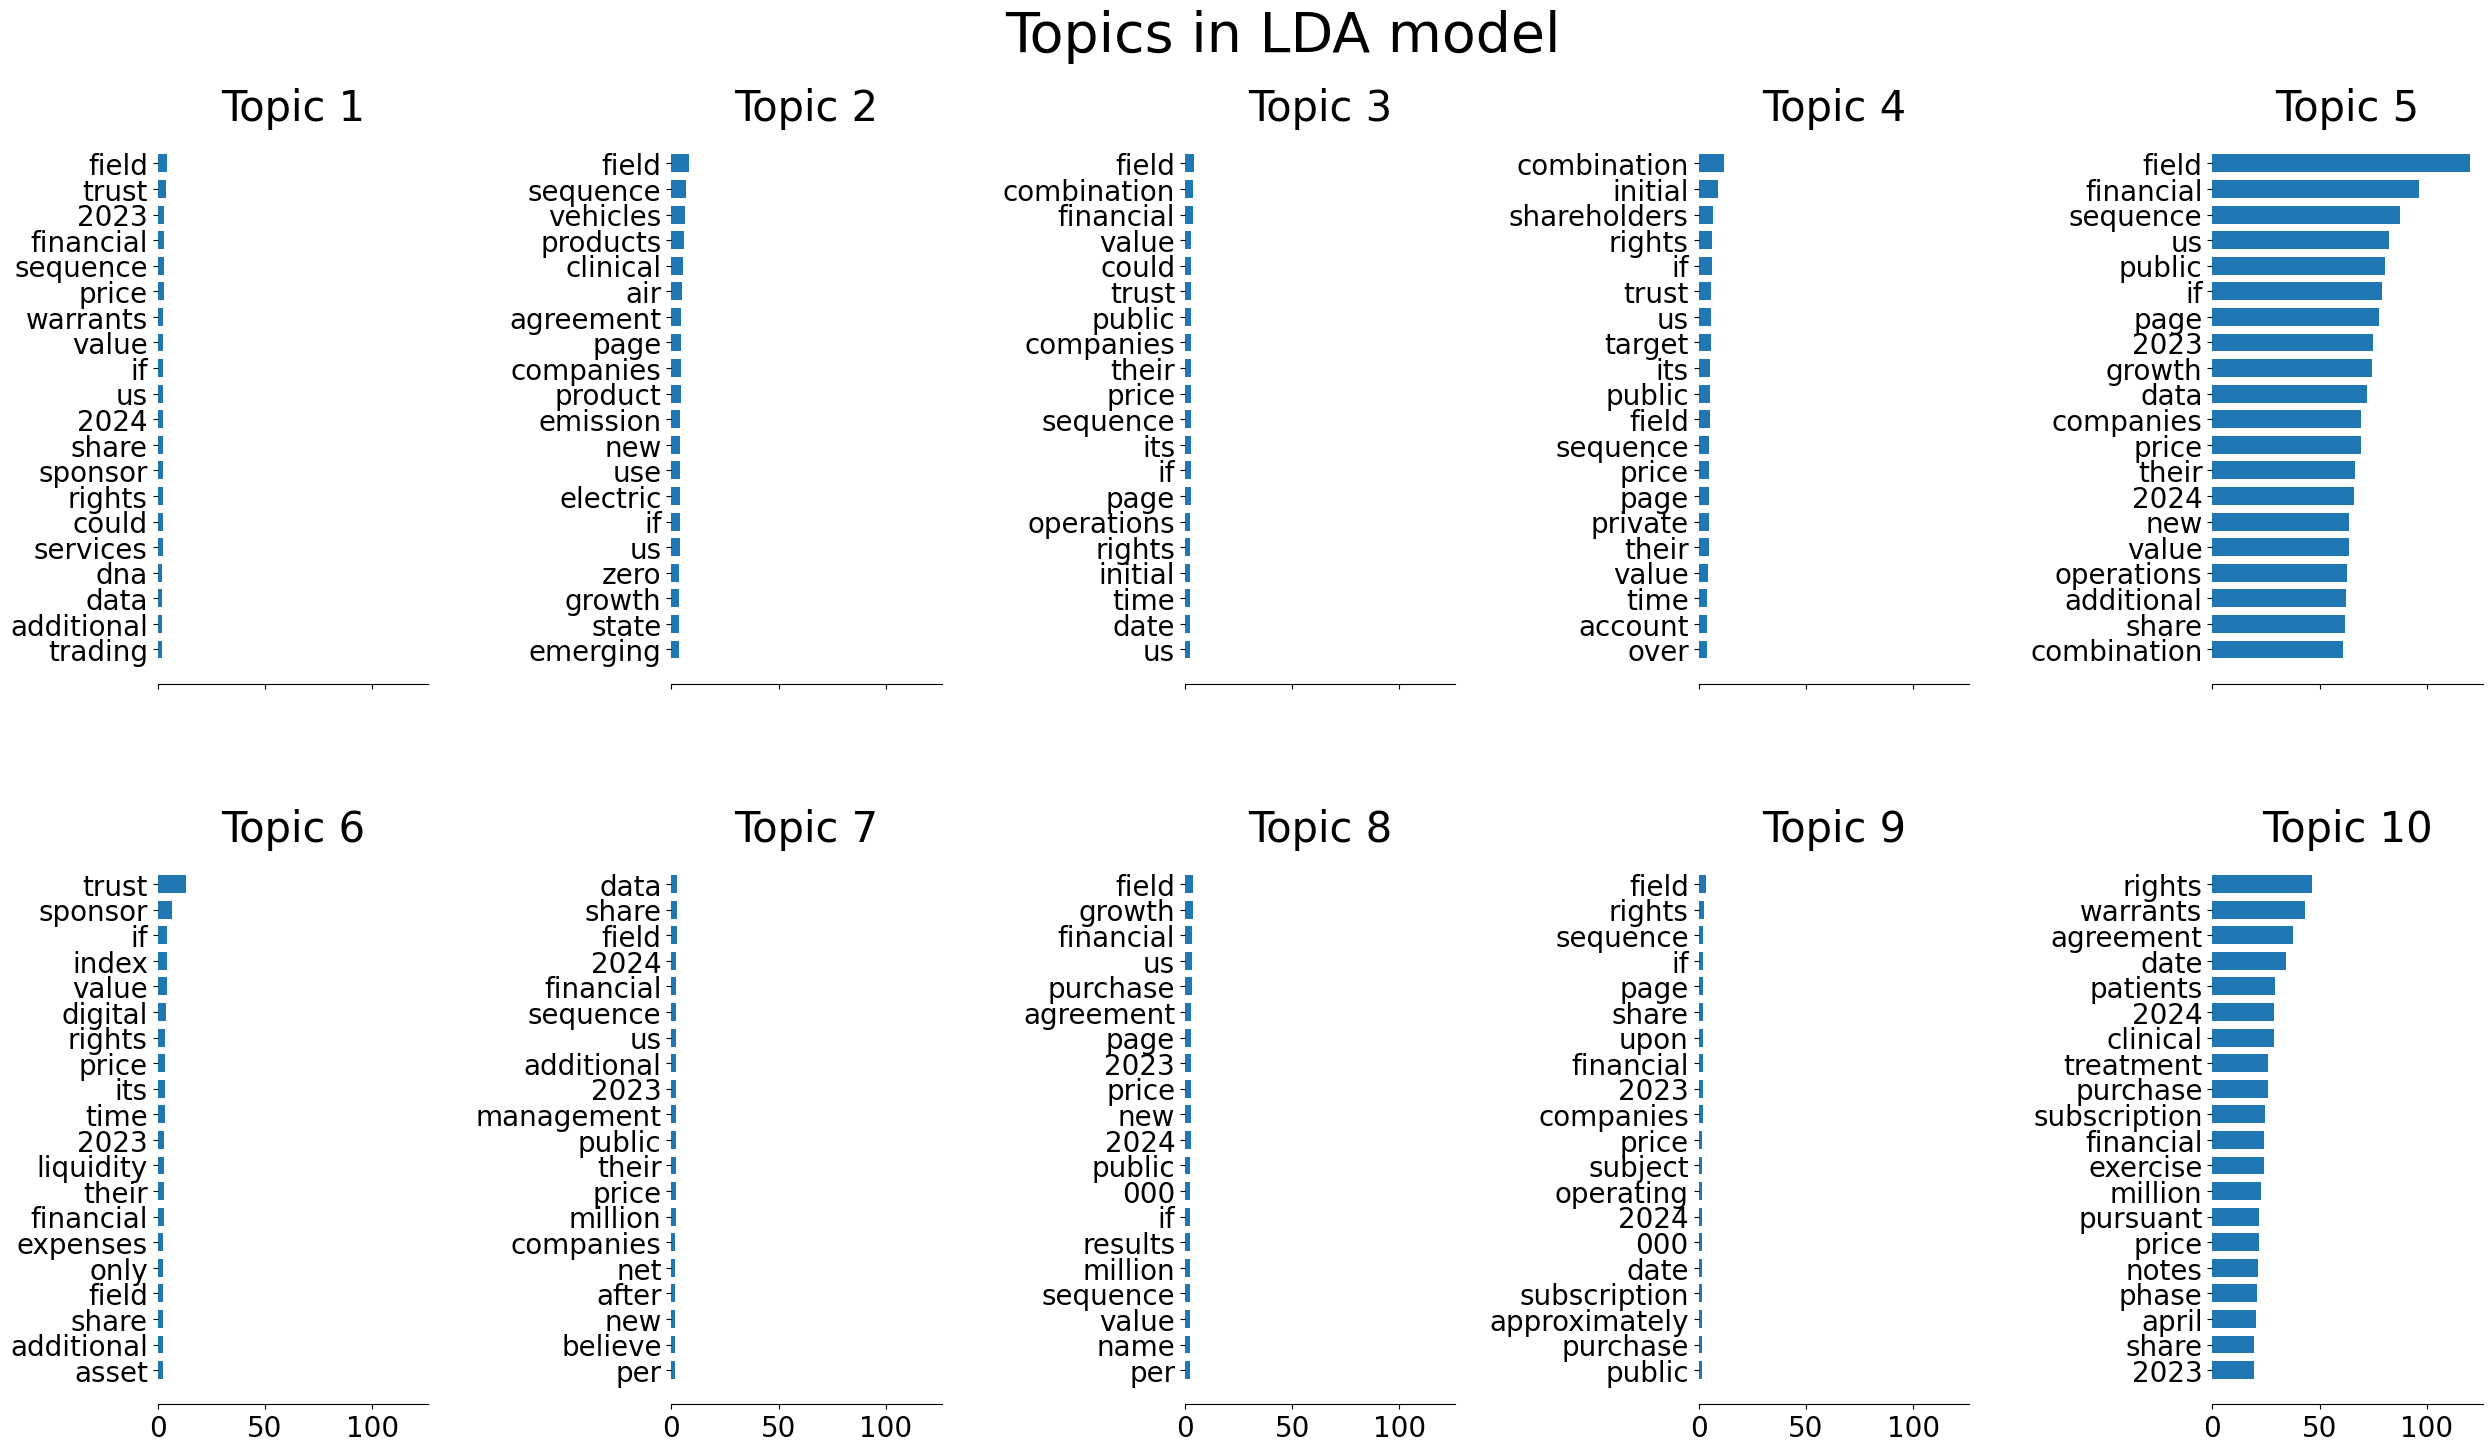

In [7]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (len(summaries_no_urls), n_features),
)

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

Not the best results, there is probably more work to do in terms of stop words. Topic 2 is the most cohesive, containing: vehicles, air, emission, electric. Lets increase our iterations from 5 to 100 and see if results change.



 Fitting LDA models with tf features, n_samples=44 and n_features=10000...
done in 19.433s.


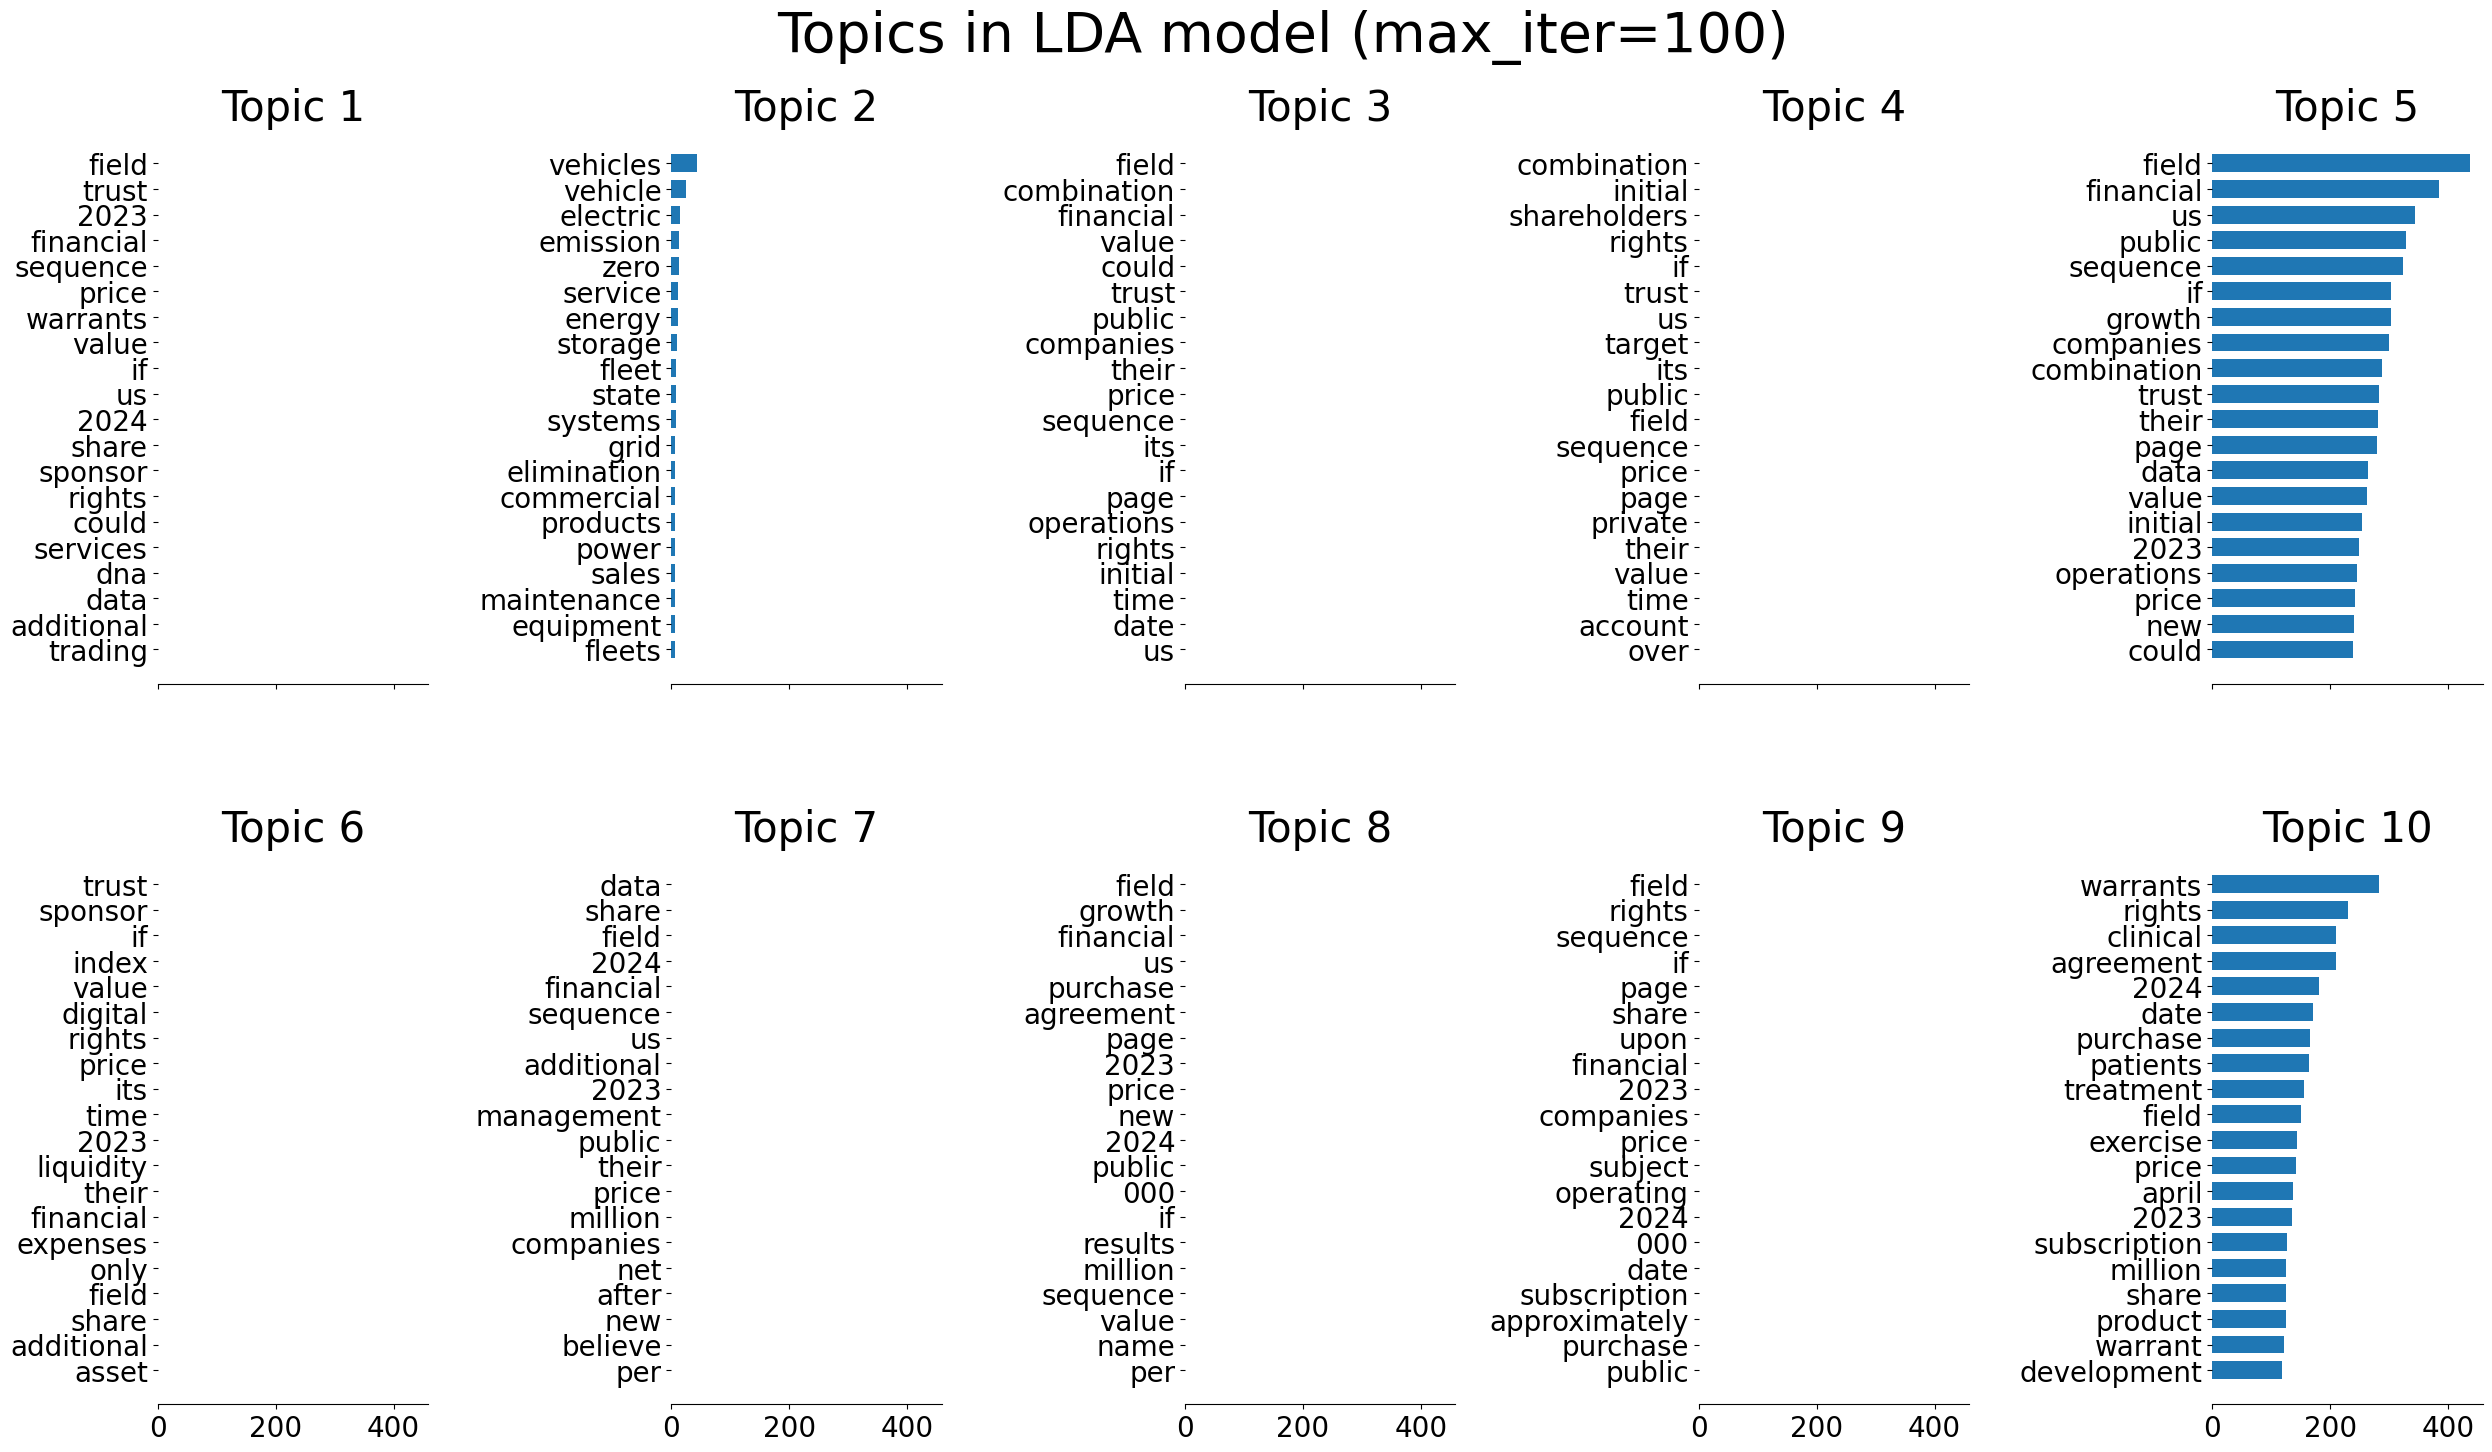

In [8]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (len(summaries_no_urls), n_features),
)

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=100,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model (max_iter=100)")

Takes a couple more seconds, more topic 2 has become much more cohesive. It now includes: vehicle(s), electric, emission, zero, energy, storage, fleet(s), grid, and power.
Lastly, we will try again with no stopwords, just out of curiousity.

In [ ]:
print("Extracting tf features for LDA with no stopwords...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=[]
)

t0 = time()
tf = tf_vectorizer.fit_transform(summaries_no_urls)

print("done in %0.3fs." % (time() - t0))
print()

tf

with np.printoptions(threshold=np.inf):
  print(tf_vectorizer.get_feature_names_out())

In [ ]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features (no stopwords), n_samples=%d and n_features=%d..."
    % (len(summaries_no_urls), n_features),
)

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model (no stopwords)")



 Fitting LDA models with tf features (no stopwords, max_iter=100), n_samples=44 and n_features=10000...
done in 8.193s.


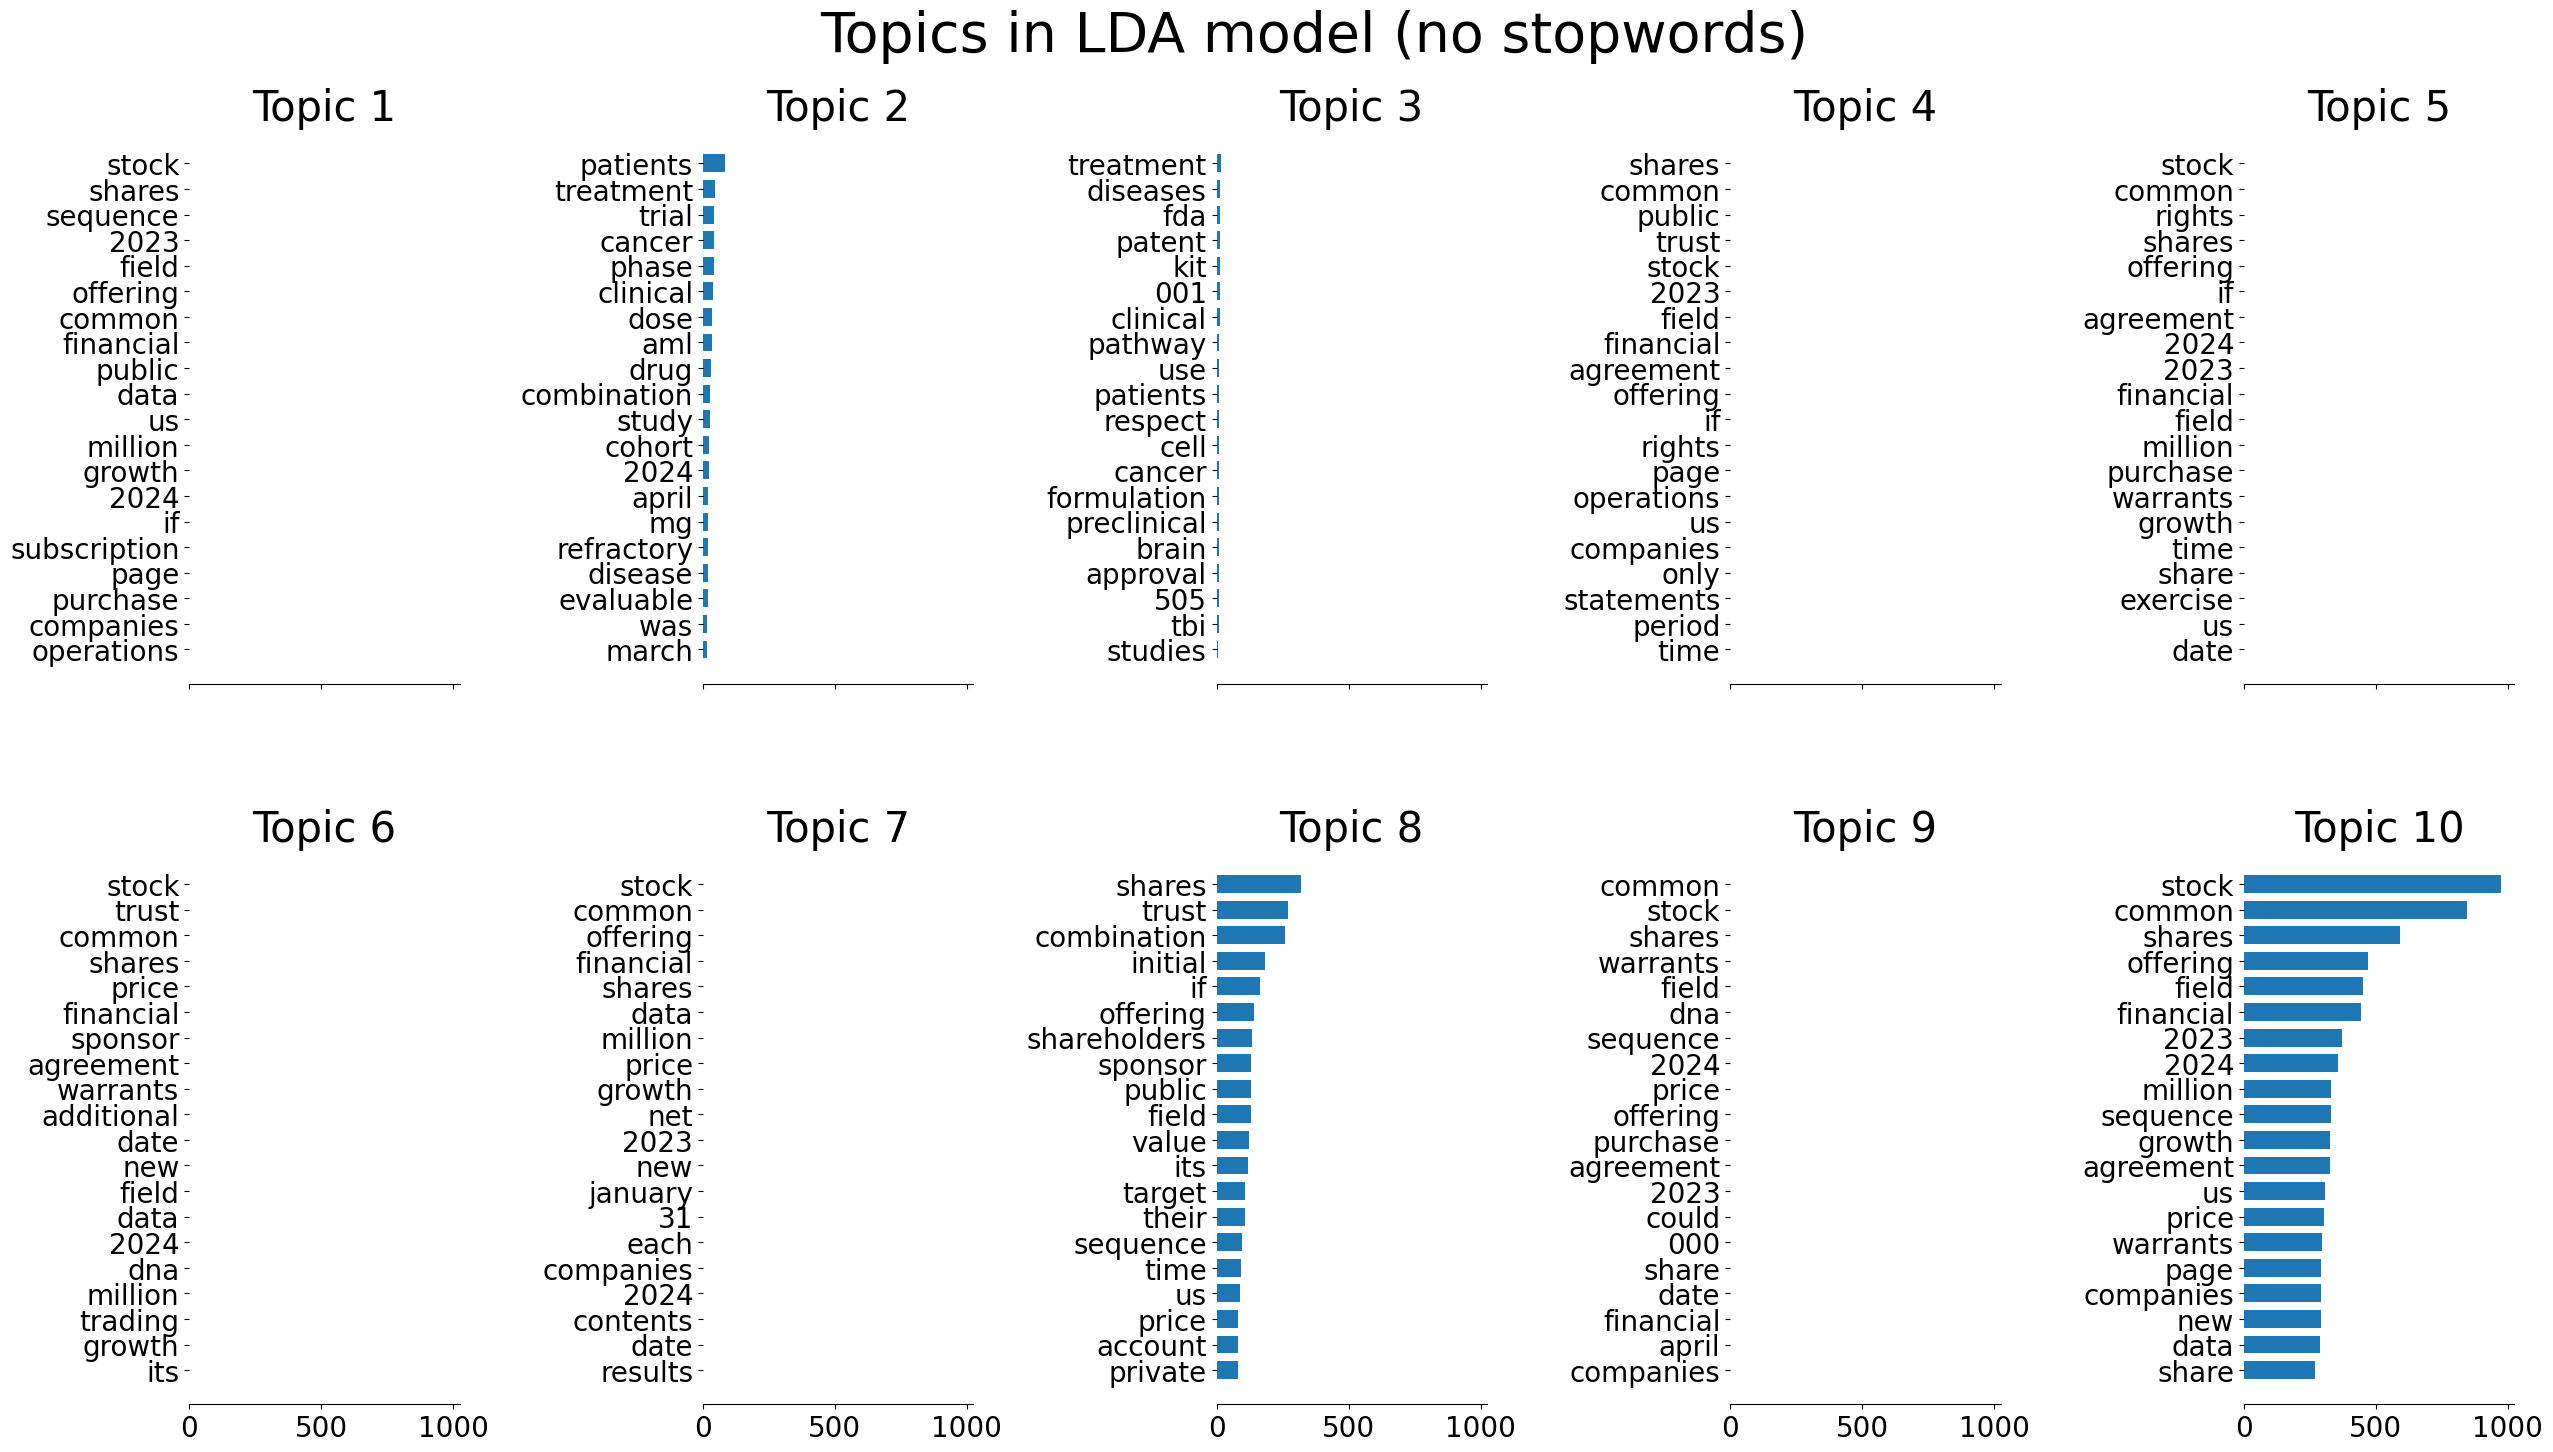

In [11]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features (no stopwords, max_iter=100), n_samples=%d and n_features=%d..."
    % (len(summaries_no_urls), n_features),
)

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=100,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model (no stopwords)")

Interesting, there is no longer a topic about electric/energy, but rather topics 2 and 3 have emerged as medical-related topics. Patients, treatment, trial, and cancer are the top words here, with both topics (2 and 3) relatively similar. Lets move on to NMF.  

# NMF

Extracting tf-idf features for NMF...
done in 0.402s.
Fitting the NMF model (Frobenius norm) with tf-idf features, max n_samples=44 and n_features=10000...


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 0.479s.


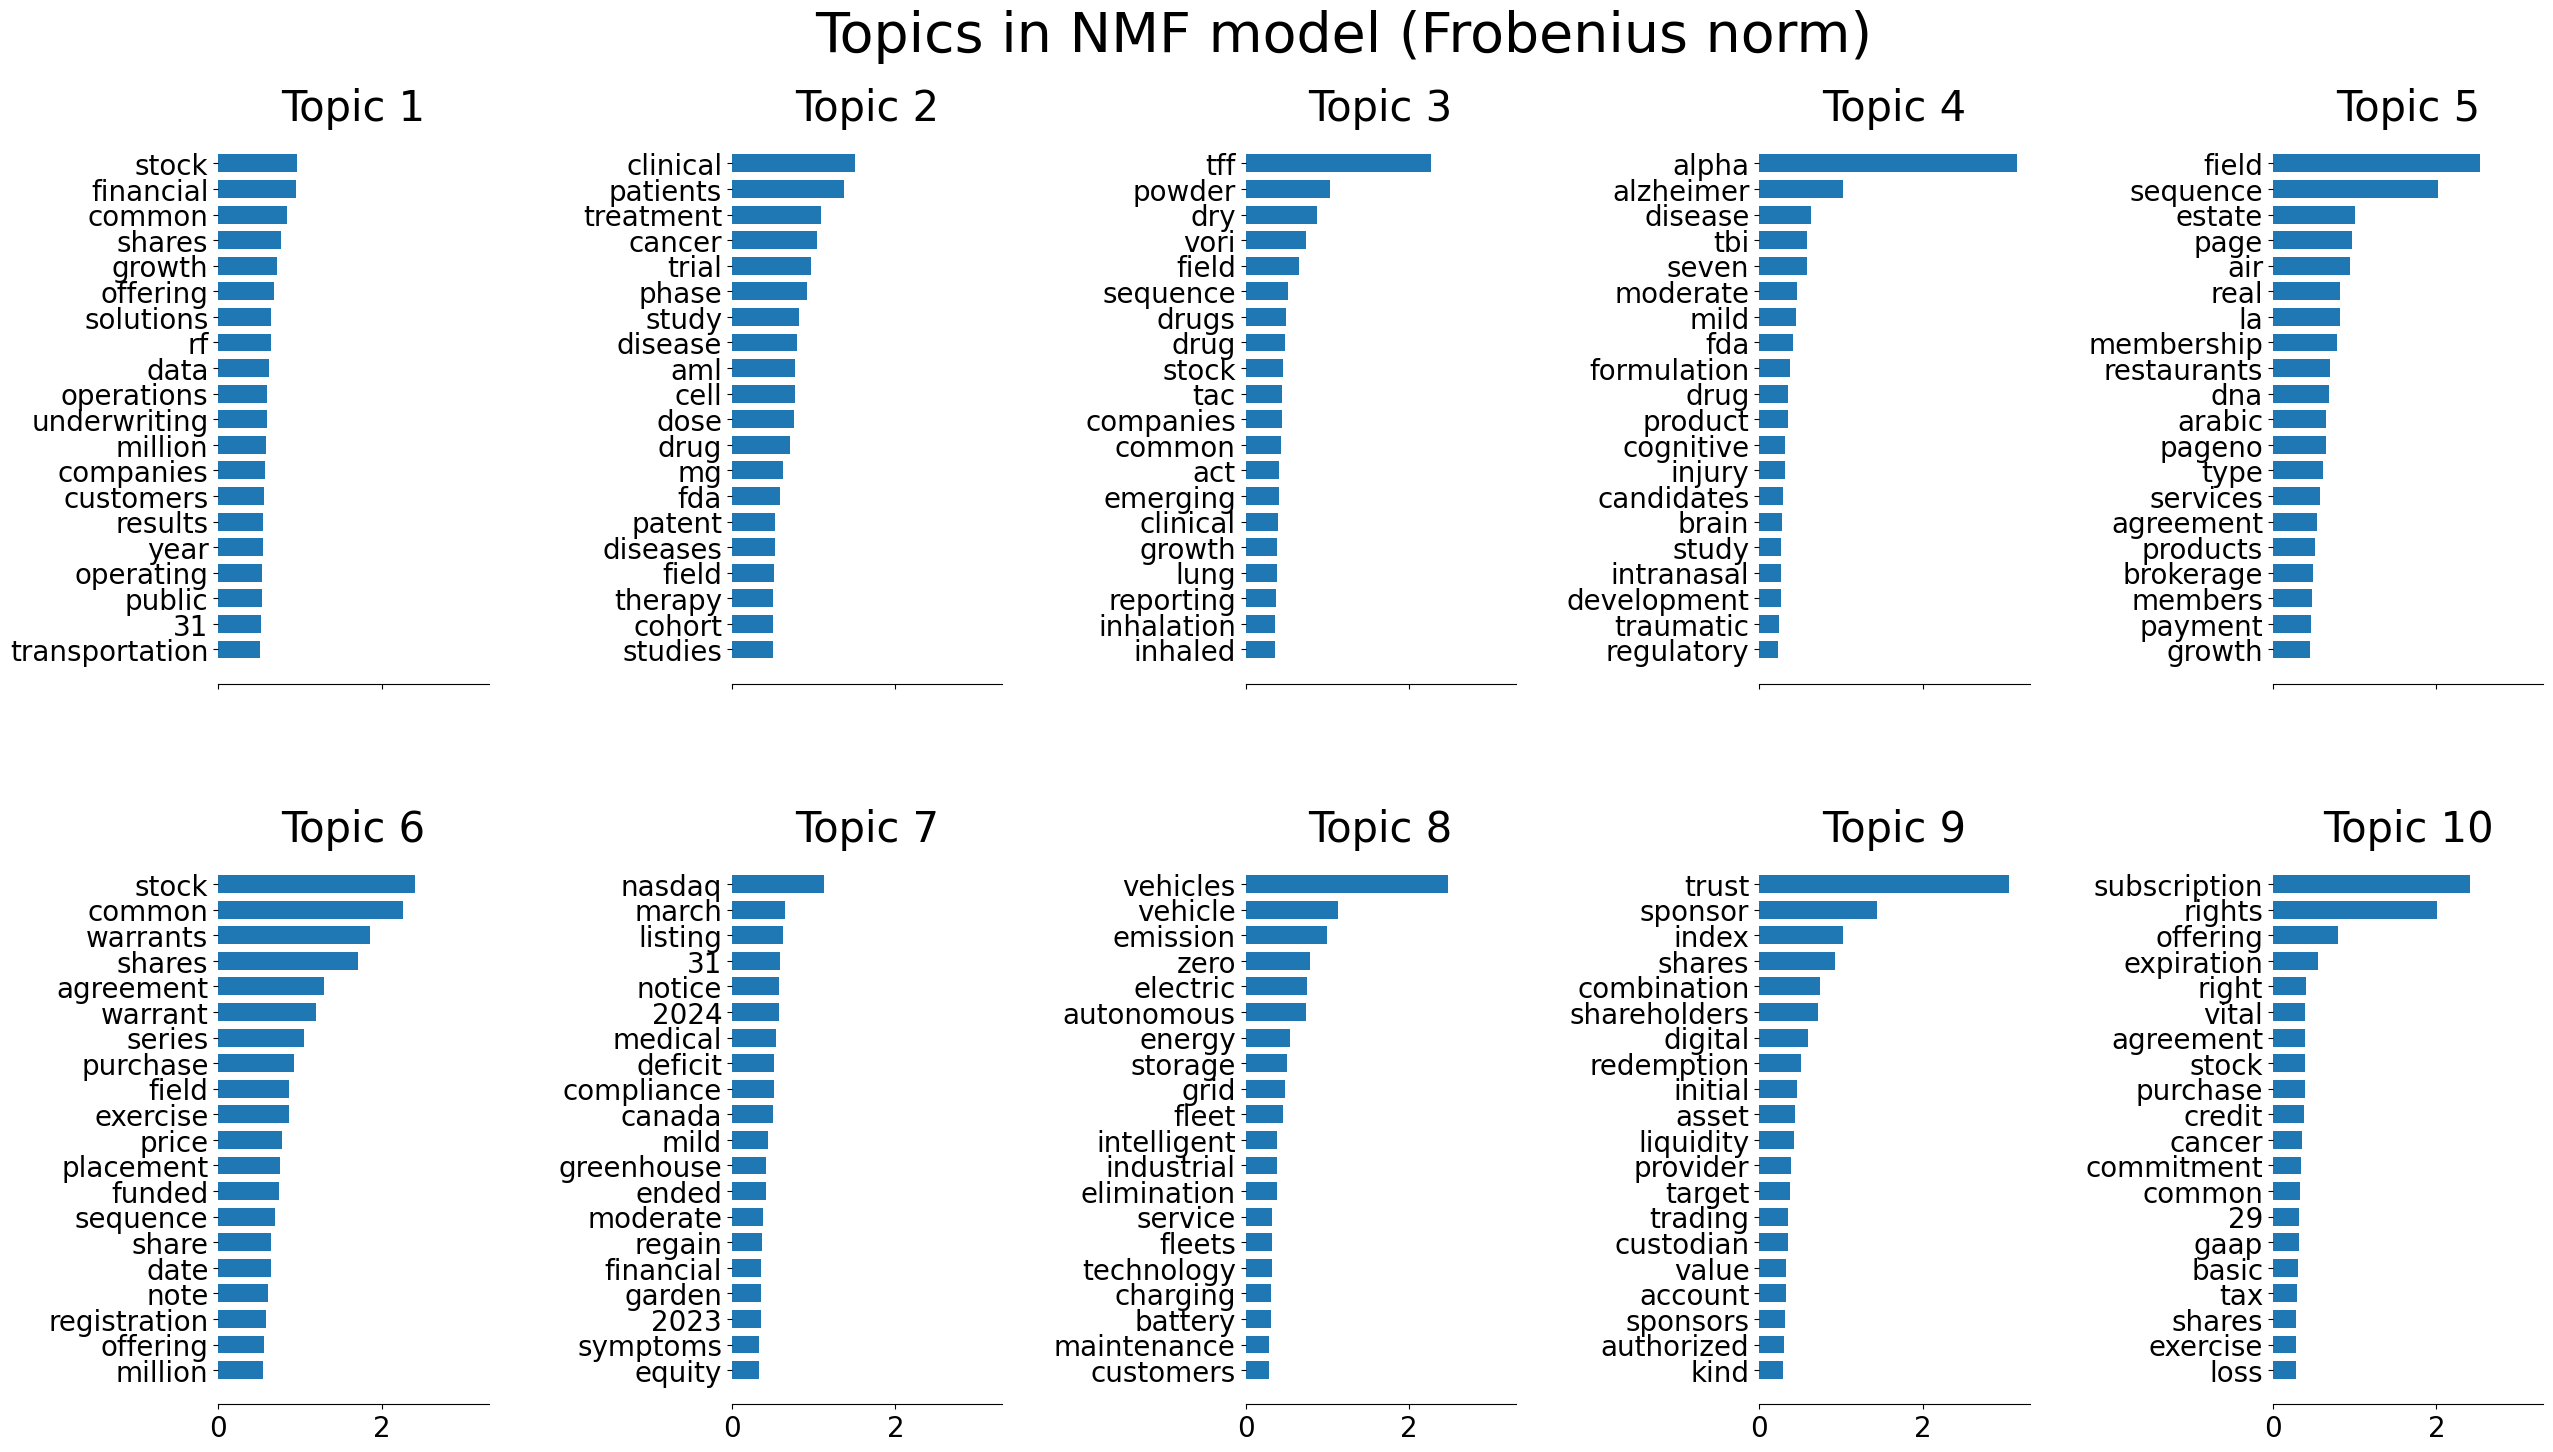



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, max n_samples=44 and n_features=10000...
done in 1.421s.


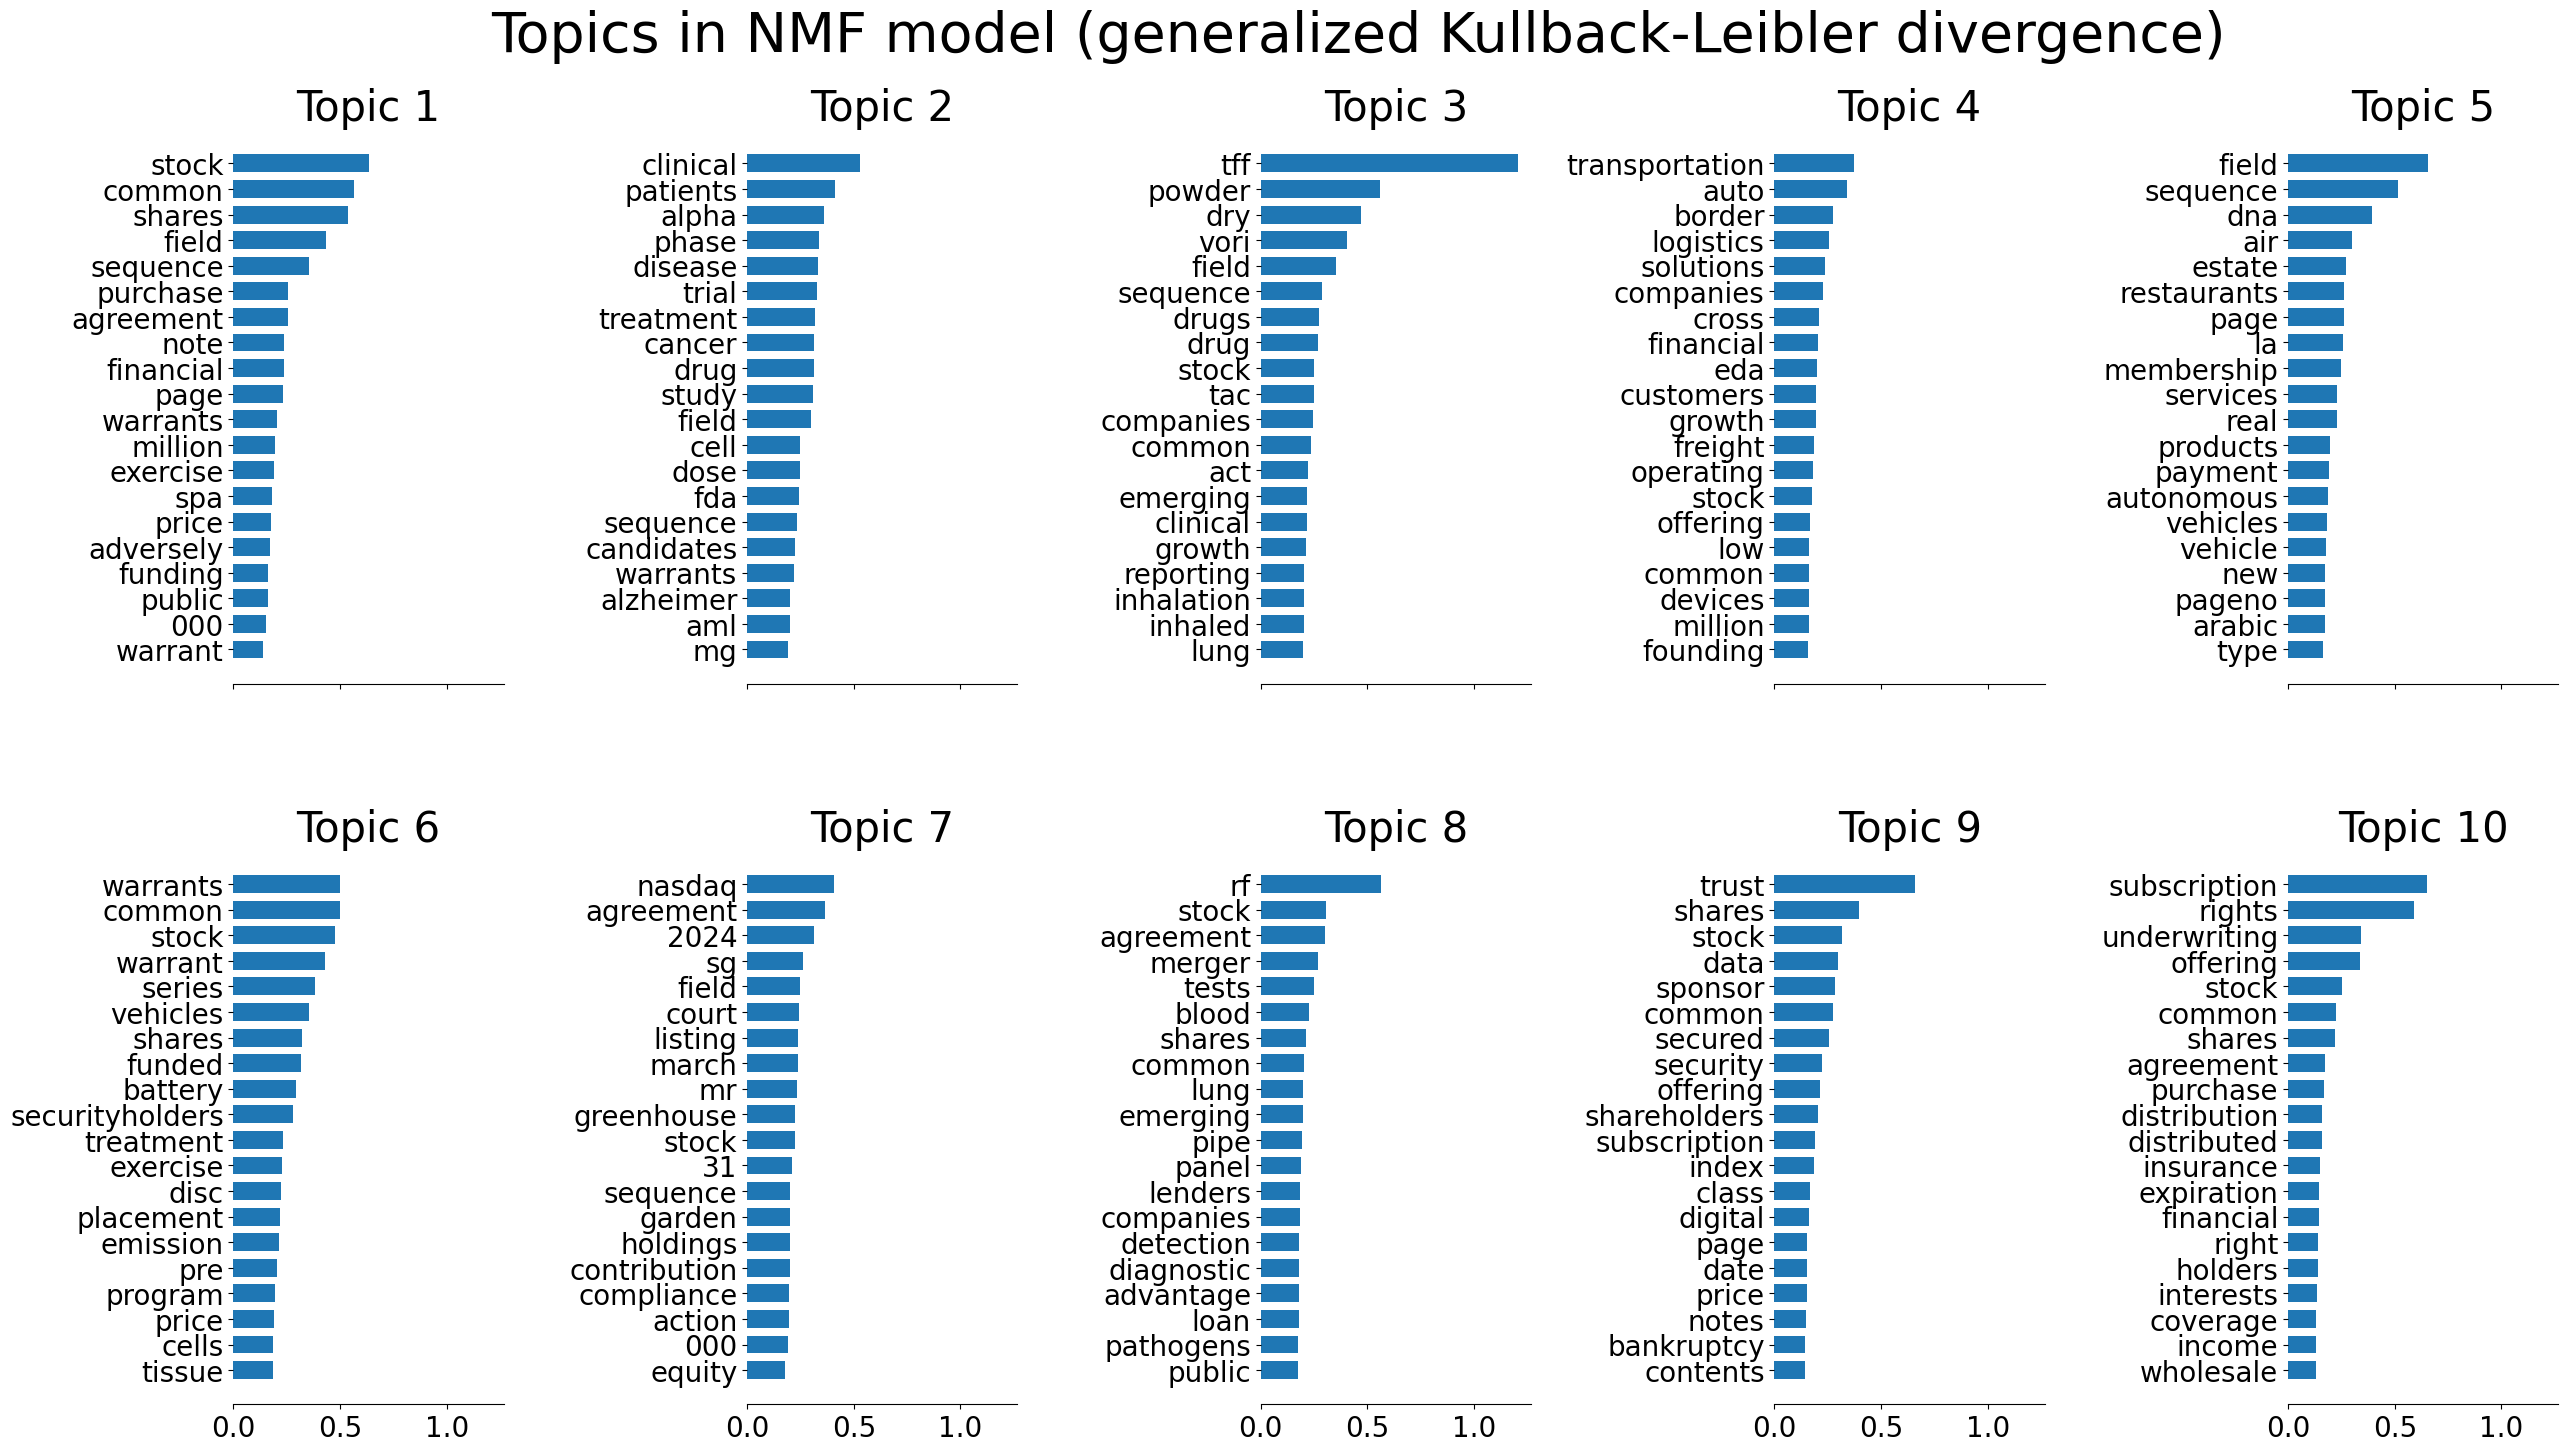

In [12]:
# First, tokenization

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(summaries_no_urls)
print("done in %0.3fs." % (time() - t0))


# Apply analysis

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "max n_samples=%d and n_features=%d..." % (len(summaries_no_urls), n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_topics,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, max n_samples=%d and n_features=%d..."
    % (len(summaries_no_urls), n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_topics,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Much clearer topics seem to be generated by NMF for us. Between the two beta-loss functions (Frobenius norm vs gen KL divergence), we get topics surrounding both medical and energy keywords, as well as transportation/logistics. Interestingly, our medical topics get more specific: we see alzheimer, cognitive, brain, and lung for the first time here.
Out of curiousity, lets run the FN beta-loss version again, since we got a warning suggesting we increase the max iterations.

Fitting the NMF model (Frobenius norm) with tf-idf features, max n_samples=44 and n_features=10000...
done in 0.813s.


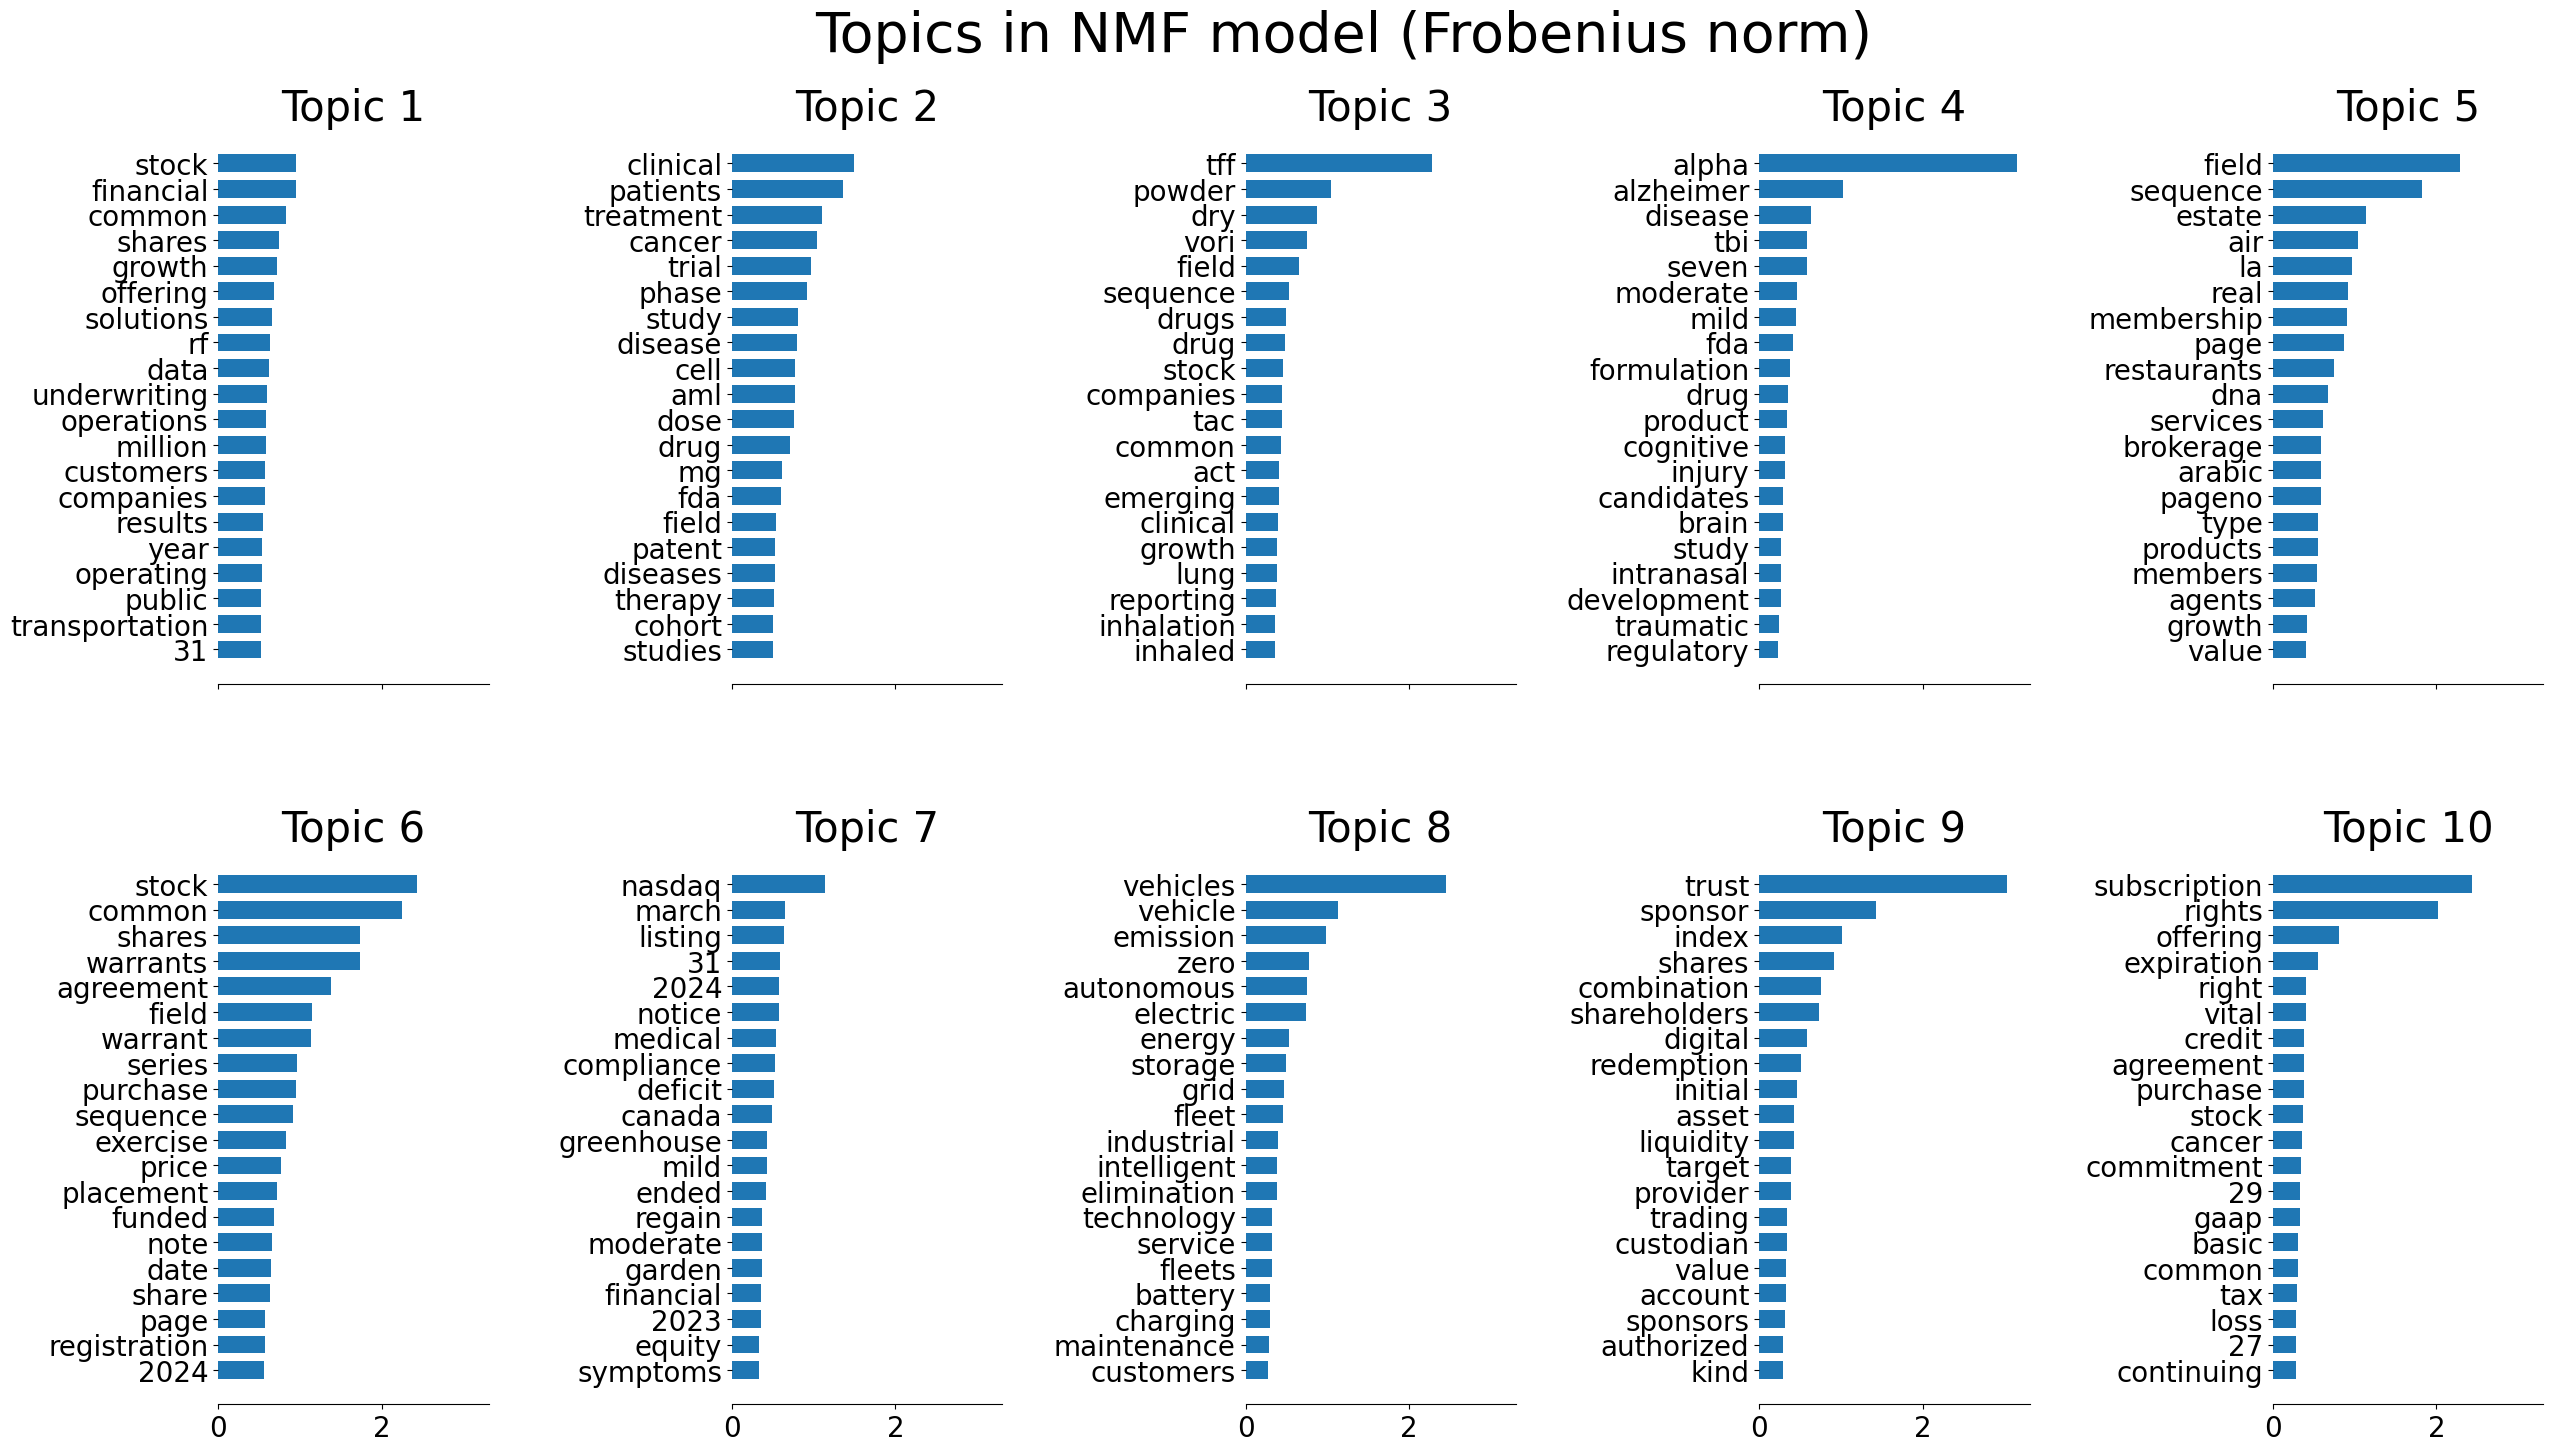

In [13]:
print(
    "Fitting the NMF model (Frobenius norm, max_iter=1000) with tf-idf features, "
    "max n_samples=%d and n_features=%d..." % (len(summaries_no_urls), n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_topics,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

Relatively similar results to the 200 iteration.

##### Risk Factors
Lets now try with a [similar sample file](https://drive.google.com/file/d/1izIW3KDEneL6iwcCaOhCNRgFmhnBN7DG/view?usp=sharing) of the risk factors sections extracted from recent S-1's. We will skip right to NMF as thats what we had better results with on the prospectus summaries.

In [ ]:
drive.mount('/content/drive')

samples_rf = []
with open('/content/drive/My Drive/Colab Notebooks/ML+DL/sample_rf.json', 'r') as sample_file:
  samples_rf = json.load(sample_file)

# Grab just the section text from our list of dicts
rf_no_urls = [list(inner_dict.values())[0] for x in samples_rf for inner_dict in x.values()]

print(rf_no_urls)
print(len(rf_no_urls))

Extracting tf-idf features for NMF...
done in 0.898s.
Fitting the NMF model (Frobenius norm) with tf-idf features, max n_samples=67 and n_features=10000...


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


done in 5.226s.


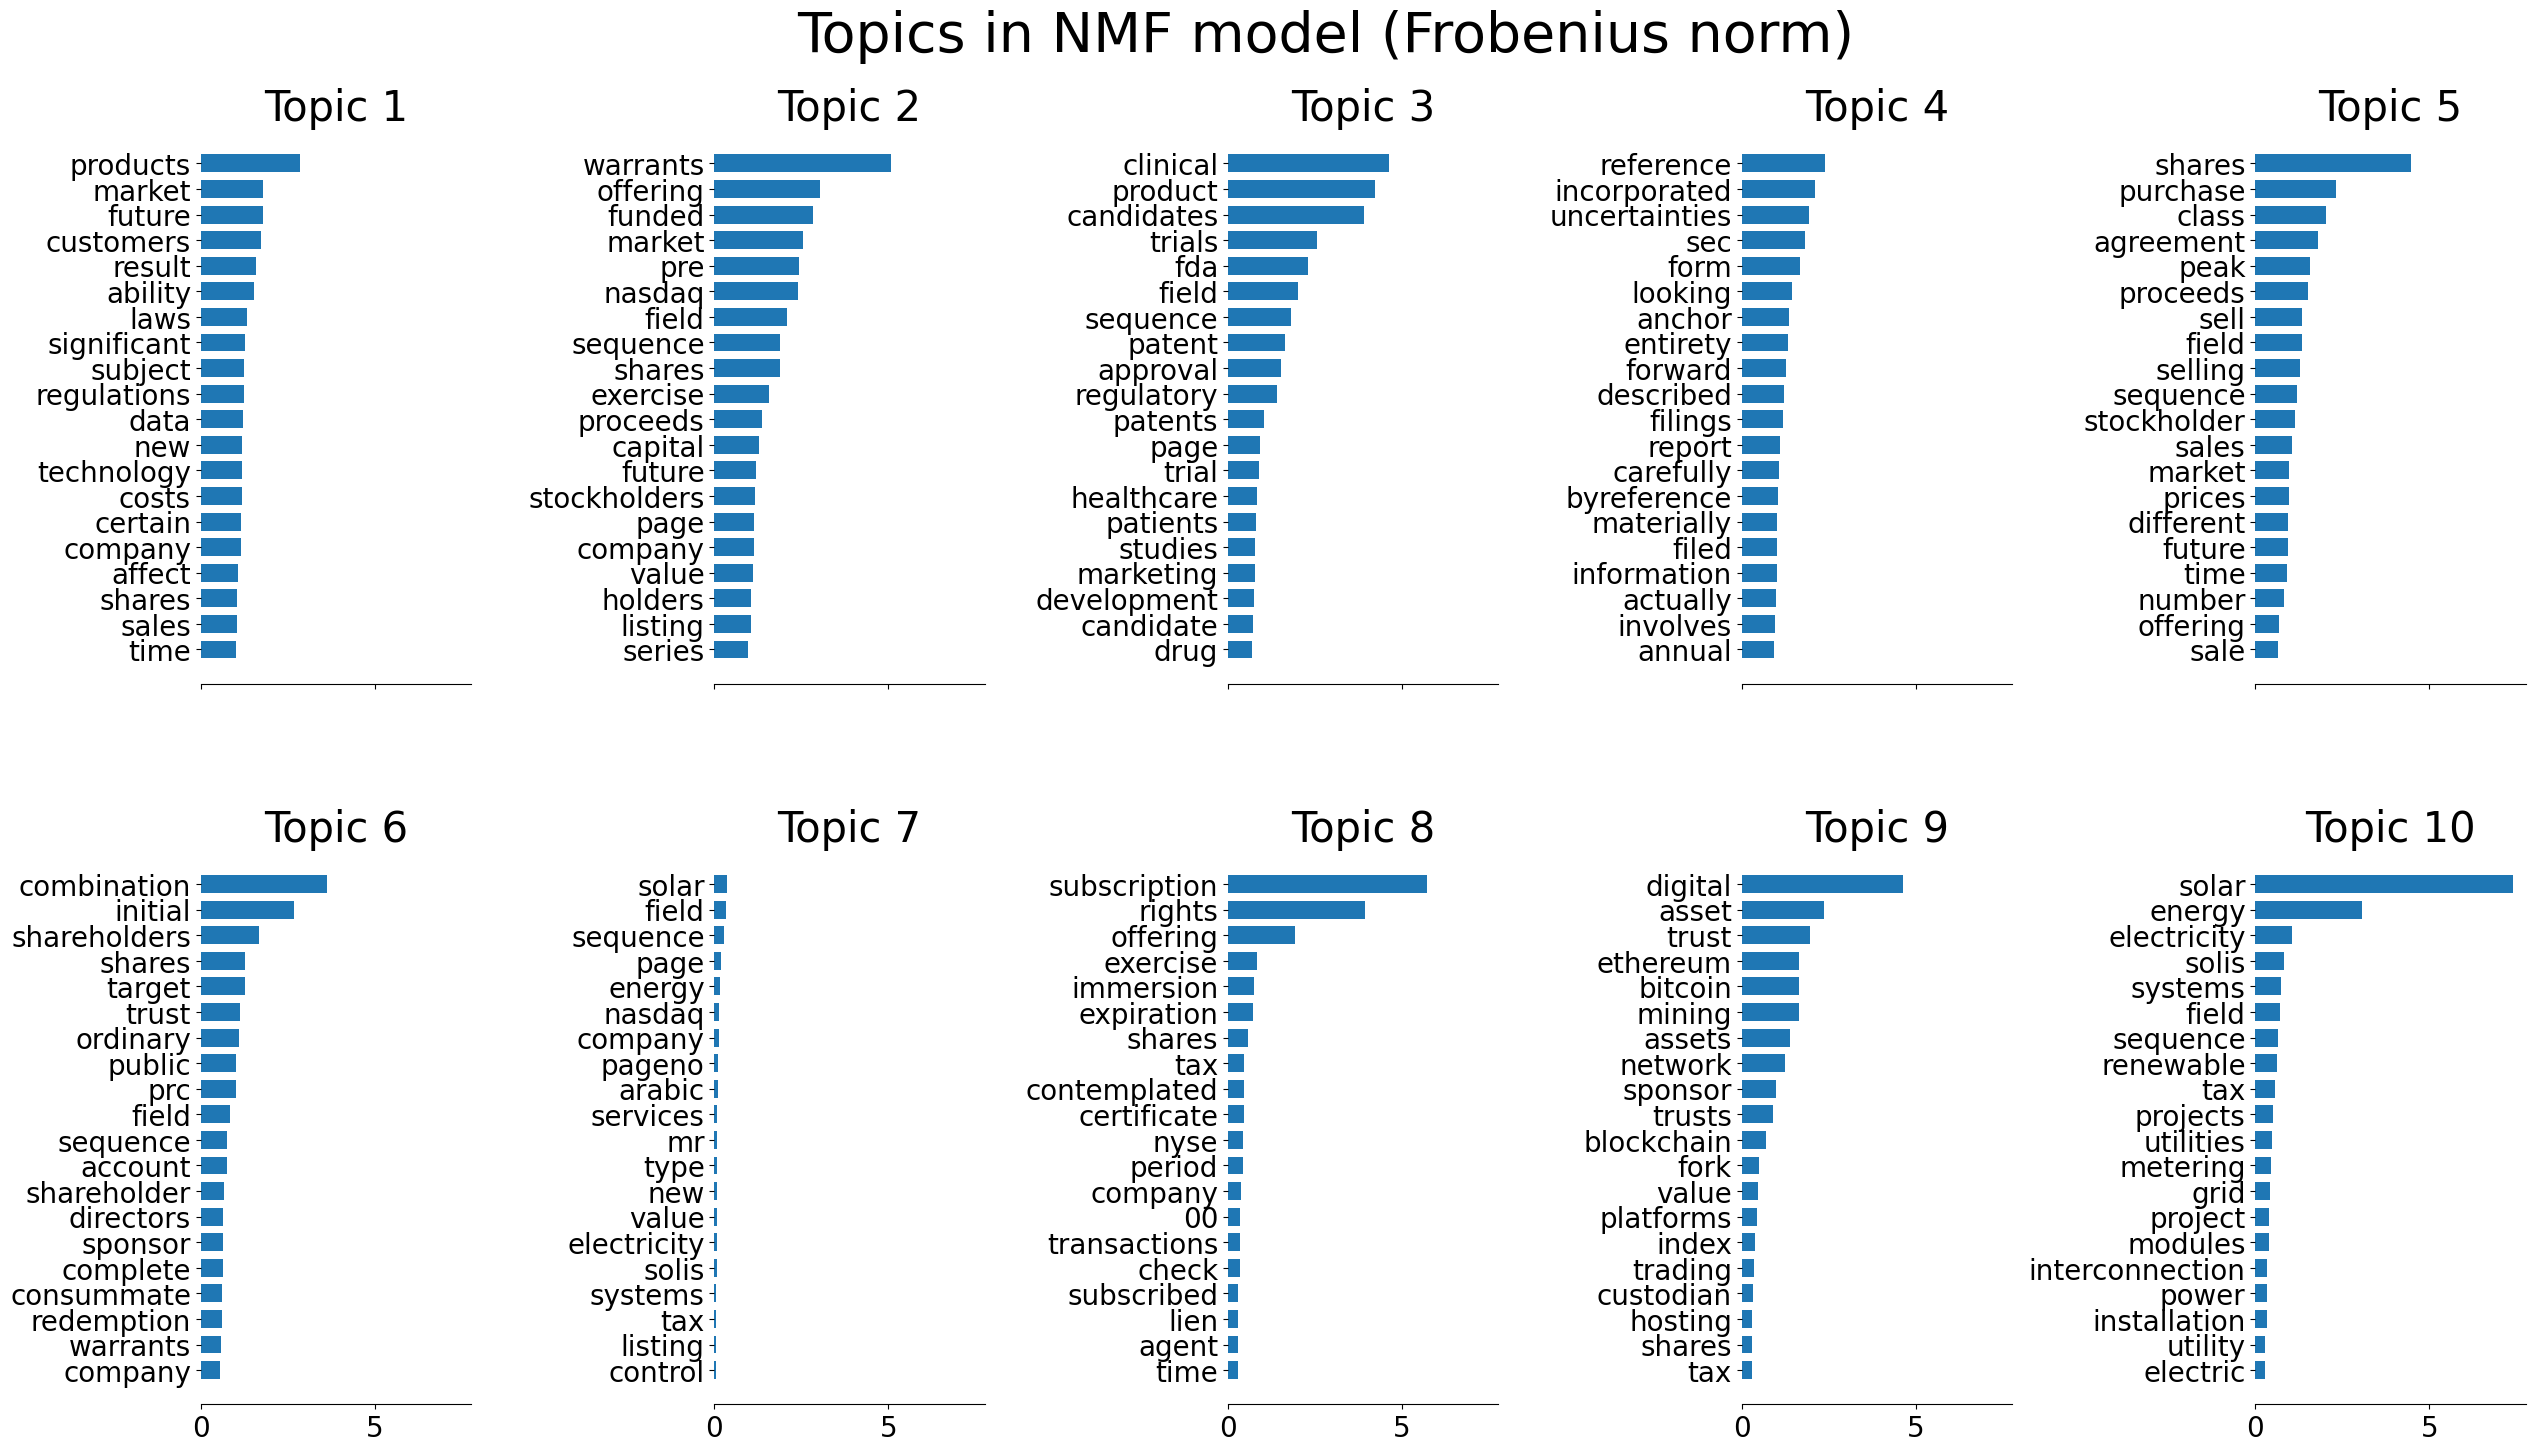



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, max n_samples=67 and n_features=10000...
done in 3.219s.


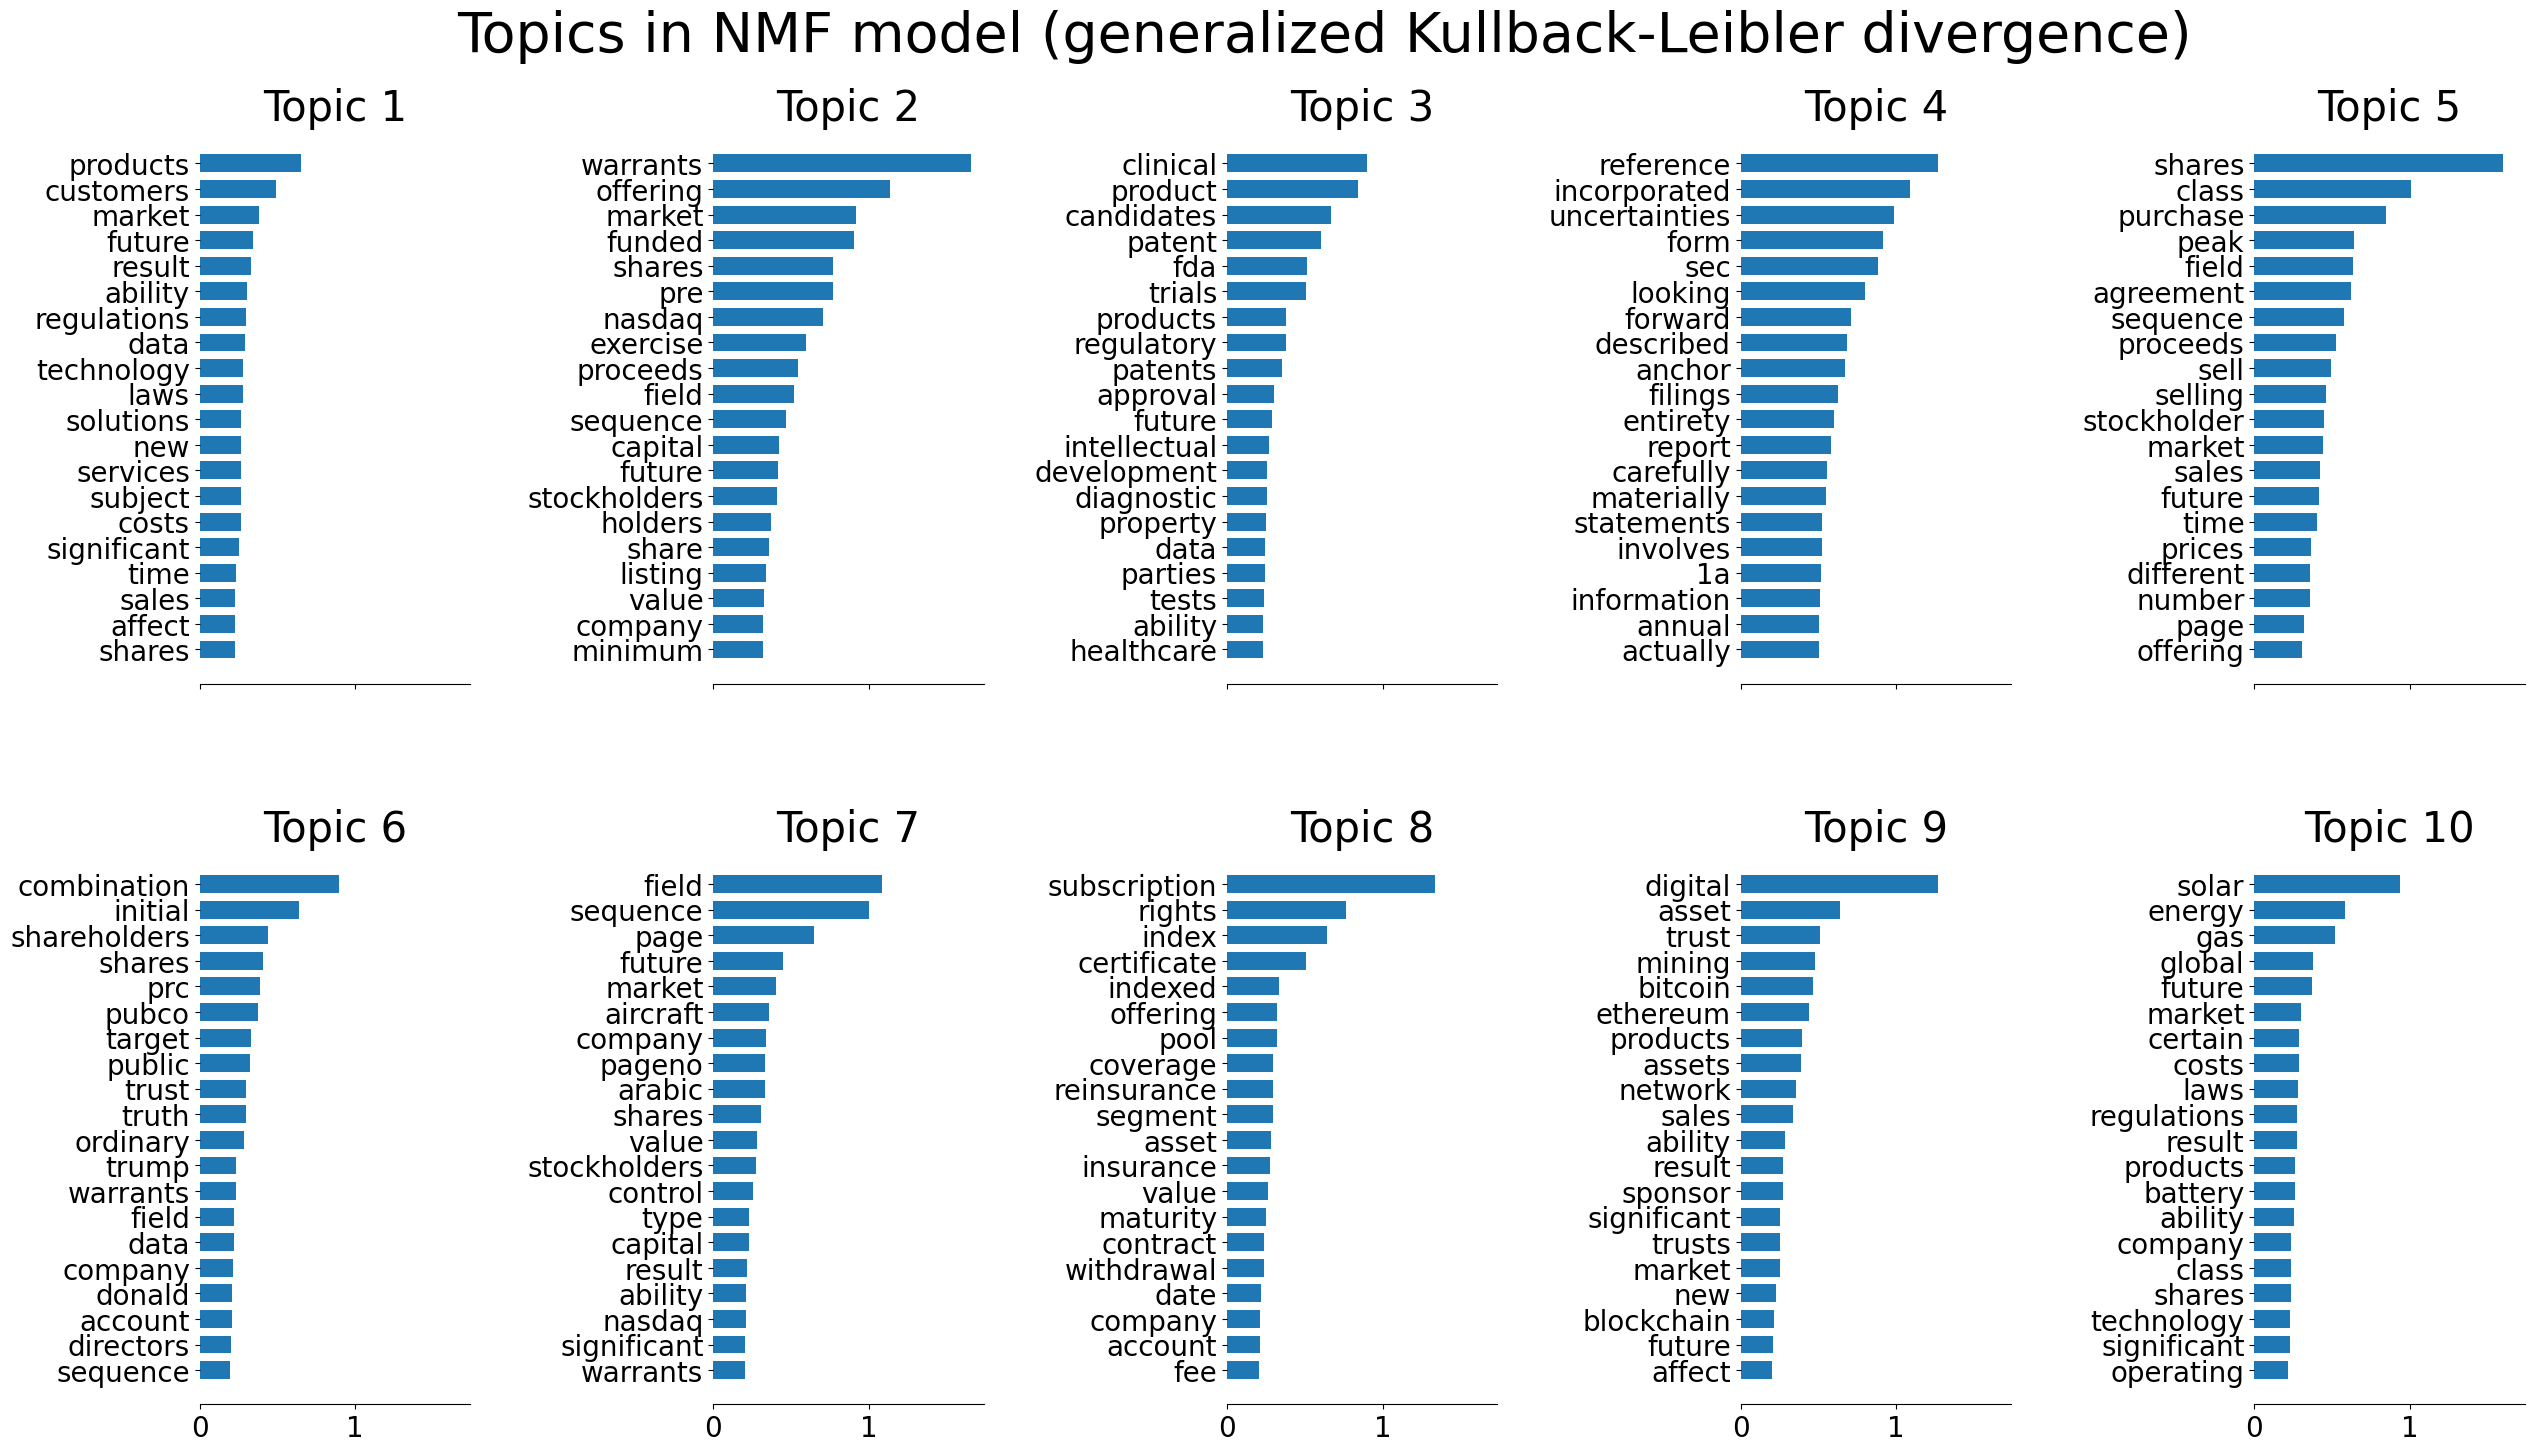

In [15]:
# First, tokenization

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(rf_no_urls)
print("done in %0.3fs." % (time() - t0))


# Apply analysis

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "max n_samples=%d and n_features=%d..." % (len(rf_no_urls), n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_topics,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, max n_samples=%d and n_features=%d..."
    % (len(rf_no_urls), n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_topics,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Three topics of interest emerge, with some overlap to our summary topics: health, energy, and interestingly enough: digital assets. You can also find both donald and trump in there, lol. The medical topic has slightly shifted to mostly be emphasizing clinical trials, patents, and FDA regulation/approval. Solar also has moved to the top of the energy topics. In particular, topic 10 of the KB beta loss run reads in interesting order: solar, energy, gas, global, future, market, certain, (cont).
The digital asset topic is intriguing as well. Digital and asset are literally the top words of the topic, and are followed by words including mining, bitcoin, ethereum, network, blockchain, fork, and platform.

#### So what did we learn
For one, that NMF seems to be more effective than LDA in our case, although we do have some more work to do in terms of stop-word optimization. Next, that from what we could discern, companies seem to be discussing in their prospectus summaries (essentially giving light into what they are in the market to do, what opening/need do they see which they can fill):

*   Cancer and both cognitive and pulmonary medical issues/treatments
*   Electric + autonomous vehicles, battery charging, and energy storage
*   Transportation, logistics, freight, border (Mexico border? More investig. to do)

And lastly, in the risk factors sections of new S-1 filings, where companies discuss the potential headwinds they and the market they hope to compete in may face, we discerned the following topics:

*   The outcomes of clinical trials and FDA approval/regulation
*   The future of global energy markets, particularly solar, electricity, and gas, including costs and regulations
*   Digital assets (bitcoin, eth, etc), blockchains, and networks

In further analysis, I will likely plot topics over multiple years and observe any changes in trends.

